## Tutorial example for cell type deconvolution using LETSmix
In this tutorial, we show how to apply LETSmix to deconvolute cell type proportions for human pancreatic ductal adenocarcinoma (PDAC-A) data. Both scRNA-seq and ST data were provided at https://zenodo.org/records/11114959.

### 1. import packages and set hyperparameters

In [1]:
import LETSmix
import os
import json
from time import time, ctime
import scanpy as sc
from skimage import io
import numpy as np
import torch
import pandas as pd
from scipy.spatial.distance import jensenshannon

class Args():
    def __init__(self):
        self.lr = {'sc':0.001, 'dc':0.001}  # learning rate for source and domain classifiers
        self.bs = 1024  # batch size
        self.k = 8   # number of cells per pseudo-spot
        self.n_top_genes = 50  # number of marker genes per cell type
        self.smooth = 0.5   # degree of spatial refinement
        self.stage1 = {'interval':100, 'ite':1001}  # pretrain the source classifier
        self.stage2 = {'interval':100, 'ite':2001}  # adversarial training for both classifiers
        self.d = 10   # training iterations: domain classifier vs. source classifier
        self.num_aug = 50  # repeattedly augment the dataset to enable larger batch size and faster training.
                           # note that bs*k shoule be less than num_aug*min(len(adata_st), len(adata_sc)).
        self.device = 'cuda:4'
        self.sc_path = '/data114_2/zhanyg/data/trans/PDAC/sc_A.h5ad' 
        self.st_path = '/data114_2/zhanyg/data/trans/PDAC/st_A.h5ad' 
        self.img_path = '/data114_2/zhanyg/data/trans/PDAC/st_A_full_image.tif'
        self.logdir = '/data114_2/zhanyg/Code/y2024/LETSmix/LETSmix-git/log/'

### 2. initialize the arguments

In [2]:
args = Args()
os.makedirs(args.logdir+'figs/', exist_ok=1)
with open(args.logdir+'args.txt','w') as f:
    json.dump(args.__dict__, f, indent=2)    
t0 = time()
with open(args.logdir+'log.txt', 'w') as f:
    f.write(ctime()+'\n')

### 3. load data and the model
Cell type information are stored in adata_sc.obs['label']

Scaled image data and related information are stored in adata_st.uns.data['spatial']['histology']

Region annotations are stored in adata_st.obs['region']

To disable the using of image and region annotation information, set LETSmix.LETS_filter(img=None, regions=None)


In [3]:
adata_sc = sc.read_h5ad(args.sc_path)
adata_st = sc.read_h5ad(args.st_path)
img = io.imread(args.img_path)

mat_sc, lab_sc, adata_st, cts_dict = LETSmix.preprocess(adata_sc, adata_st, args.n_top_genes, args.smooth, args.logdir)
mat_st = LETSmix.LETS_filter(adata_st, args.smooth, img, adata_st.obs['region'], args.device, args.logdir)
loader = LETSmix.load_data(mat_sc, lab_sc, mat_st, args.bs, args.k, args.num_aug)

model = LETSmix.LETSmix([mat_sc.shape[1], 1024, 64, 32, lab_sc.shape[1]], args.lr)
model.to(args.device)

Selected Feature Gene number 728


/home/zhanyg/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zhanyg/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/home/zhanyg/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zhanyg/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnD

LETSmix(
  (fe): Feature_extractor(
    (layers): Sequential(
      (0): Linear(in_features=728, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (sc): Source_Classifier(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=20, bias=True)
      (1): Softmax(dim=1)
    )
  )
  (dc): Domain_Classifier(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  )
)

### 4. define how to evaluate model performance in the traning process

In [4]:
# calculate the general cell type compositioin in the scRNA-seq dataset for the JSD computation
ctr_sc = LETSmix.cal_ctr_sc(adata_sc, cts_dict)

def cal_metric(loader, model, adata_st, cts_dict, ctr_sc, device):
    pred = LETSmix.get_predictions(loader, model, device)

    er_all = []
    for region in adata_st.uns['cts_dom_A'].keys():
        idx = np.nonzero(adata_st.obs.region.values==region)[0]
        pred_ct = np.zeros(len(pred))
        for ct in adata_st.uns['cts_dom_A'][region]:
            pred_ct += pred[:,cts_dict[ct]]
        if np.sum(pred_ct) == 0:
            er_all.append(0)
        else:
            er_all.append(np.sum(pred_ct[idx]) / np.sum(pred_ct))
    
    ctr_st = np.sum(pred, 0) / len(pred)
    jsd = jensenshannon(ctr_st, ctr_sc)
    return {'ER':np.mean(er_all), 'JSD':jsd}, pred

def evaluation(loader, model, adata_st, cts_dict, ctr_sc, device, ite, t0, stage, logdir):
    global pred_t_best, res_epoch, t_best
    model.eval()
    res, pred_t = cal_metric(loader, model, adata_st, cts_dict, ctr_sc, device)
    res_epoch['ER'].append(res['ER'])
    res_epoch['JSD'].append(res['JSD'])
    score = res['JSD']+ (1-res['ER'])
    if score < t_best:
        t_best = score
        pred_t_best = pred_t
    LETSmix.record_log(stage, ite, t0, res, t_best, logdir)
    model.train()

### 5. pretrain the source classifier

In [5]:
res_epoch = {'JSD':[], 'ER':[]}
t_best = np.inf
ite = 0
while(1):
    for (xs, ys) in loader['s_train']:
        ite += 1
        if ite == args.stage1['ite']:
            break
        xs, ys = xs.to(args.device), ys.to(args.device)
        loss = model(xs, ys, mode='pretrain')
        if ite % args.stage1['interval'] == 0:
            evaluation(loader['t_eval'], model, adata_st, cts_dict, ctr_sc, args.device, ite, t0, 1, args.logdir)
    if ite == args.stage1['ite']:
        break

S1_ite 100, 0m, JSD 0.537, ER 0.464, t_best 1.073
S1_ite 200, 0m, JSD 0.483, ER 0.486, t_best 0.998
S1_ite 300, 1m, JSD 0.454, ER 0.493, t_best 0.961
S1_ite 400, 1m, JSD 0.435, ER 0.478, t_best 0.957
S1_ite 500, 1m, JSD 0.490, ER 0.481, t_best 0.957
S1_ite 600, 1m, JSD 0.459, ER 0.479, t_best 0.957
S1_ite 700, 1m, JSD 0.448, ER 0.469, t_best 0.957
S1_ite 800, 1m, JSD 0.429, ER 0.469, t_best 0.957
S1_ite 900, 1m, JSD 0.431, ER 0.467, t_best 0.957
S1_ite 1000, 1m, JSD 0.463, ER 0.479, t_best 0.957


### 6. adversarial training

In [6]:
t_best = np.inf
ite = 0
acc_d = []  # domain discrimination accuracy
yd = torch.cat([torch.zeros(args.bs), torch.ones(args.bs)]).to(torch.int64).to(args.device)  # domain label
count = 0
while(1):
    for xs, ys, xt in loader['t_train']:
        count += 1
        xs, ys, xt = xs.to(args.device), ys.to(args.device), xt.to(args.device)
        acc_d.append(model(torch.cat([xs, xt]), ys, yd, mode='dc'))
        if count % args.d == 0:
            ite += 1
            if ite == args.stage2['ite']:
                break
            yd = (yd==0).long()  # invert domain label
            model(torch.cat([xs, xt]), ys, yd, mode='train')
            yd = (yd==0).long()
            if ite % args.stage2['interval'] == 0:
                evaluation(loader['t_eval'], model, adata_st, cts_dict, ctr_sc, args.device, ite, t0, 2, args.logdir)
    if ite == args.stage2['ite']:
        break

S2_ite 100, 3m, JSD 0.270, ER 0.232, t_best 1.038
S2_ite 200, 5m, JSD 0.208, ER 0.504, t_best 0.705
S2_ite 300, 6m, JSD 0.145, ER 0.316, t_best 0.705
S2_ite 400, 8m, JSD 0.268, ER 0.430, t_best 0.705
S2_ite 500, 9m, JSD 0.231, ER 0.537, t_best 0.694
S2_ite 600, 11m, JSD 0.229, ER 0.546, t_best 0.683
S2_ite 700, 12m, JSD 0.180, ER 0.615, t_best 0.565
S2_ite 800, 14m, JSD 0.129, ER 0.564, t_best 0.565
S2_ite 900, 16m, JSD 0.270, ER 0.667, t_best 0.565
S2_ite 1000, 17m, JSD 0.398, ER 0.701, t_best 0.565
S2_ite 1100, 19m, JSD 0.392, ER 0.722, t_best 0.565
S2_ite 1200, 20m, JSD 0.231, ER 0.607, t_best 0.565
S2_ite 1300, 22m, JSD 0.244, ER 0.636, t_best 0.565
S2_ite 1400, 23m, JSD 0.254, ER 0.594, t_best 0.565
S2_ite 1500, 25m, JSD 0.254, ER 0.664, t_best 0.565
S2_ite 1600, 26m, JSD 0.266, ER 0.561, t_best 0.565
S2_ite 1700, 28m, JSD 0.292, ER 0.611, t_best 0.565
S2_ite 1800, 30m, JSD 0.205, ER 0.624, t_best 0.565
S2_ite 1900, 31m, JSD 0.193, ER 0.627, t_best 0.565
S2_ite 2000, 33m, JSD 0.17

### 7. show results

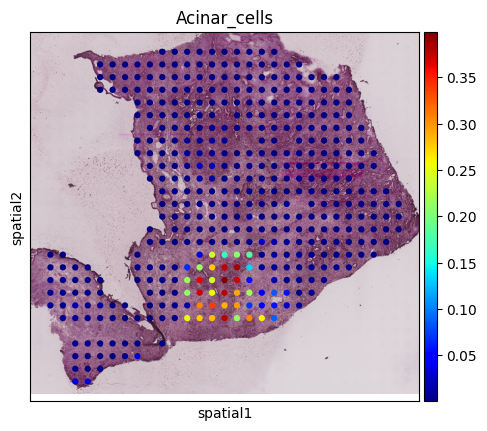

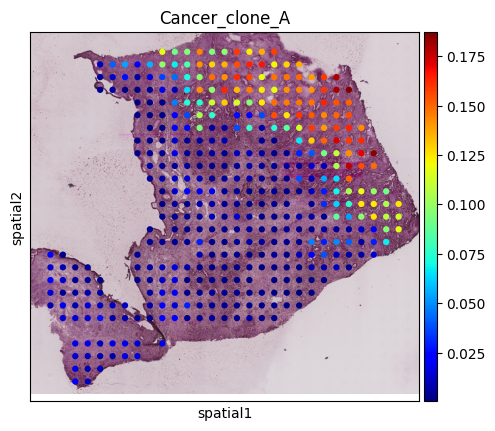

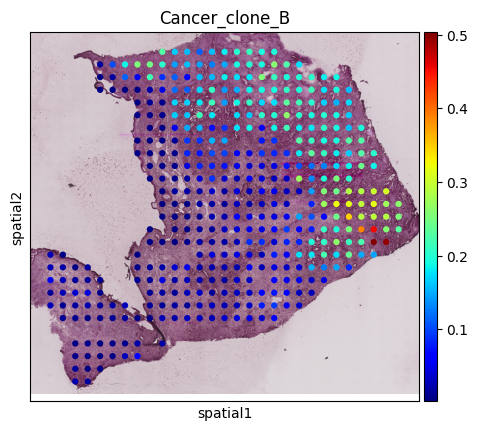

In [7]:
# plot the metric values of the training process
# LETSmix.plot_metric(res_epoch, args.logdir, show=True)

# deconvolution results visualization
for i,ct in enumerate(['Acinar_cells', 'Cancer_clone_A', 'Cancer_clone_B']):
    adata_st.obs.loc[:,'pred'] = pred_t_best[:,cts_dict[ct]]
    sc.pl.spatial(adata_st, img_key="hires", color='pred', cmap='jet',
        palette='Set1', size=1, legend_loc=None, title=ct, show=True)
pred = pd.DataFrame(pred_t_best, columns=list(cts_dict.keys()))
pred.to_csv(args.logdir+'pred.csv', index=False)